In [1]:
import os
import torch
import numpy as np
import glob
import nibabel as nib
import matplotlib.pyplot as plt

from monai.networks.nets import SwinUNETR
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Lambdad,
    NormalizeIntensityd,
)
from monai.data import Dataset, DataLoader

from functools import partial

from utils import (
    CustomConvertToMultiChannelBasedOnBratsClasses
)



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    in_channels=4,
    out_channels=3,
    img_size=96,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
).to(device)

model.load_state_dict(torch.load('best_brain_metric_model.pth'))

<All keys matched successfully>

In [3]:
instance = CustomConvertToMultiChannelBasedOnBratsClasses()

val_transform = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img"]),
        Lambdad(keys=["seg"], func=lambda x: instance(x)),
        #ConvertToMultiChannelBasedOnBratsClassesd(keys="seg"),
        #Lambdad(keys=["img", "seg"], func=lambda x: x.permute(0, 3, 1, 2)),
        NormalizeIntensityd(keys="img", nonzero=True, channel_wise=True),  # Change to global normalization
    ]
)

In [4]:
base_path = "Task01_BrainTumour/"

train_images = sorted(glob.glob(os.path.join(base_path, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(base_path, "labelsTr", "*.nii.gz")))

dataset_list = [
    {"img": image_name, "seg": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

train_dataset_list, val_dataset_list = dataset_list[:-94], dataset_list[-94:]

val_dataset = Dataset(val_dataset_list, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=os.cpu_count() // 2)

In [5]:
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[96, 96, 96],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)

seg_infers = []

with torch.no_grad():
    for batch_data in val_loader:
        image = batch_data["img"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        #print(prob.shape)
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 1
        seg_out[seg[0] == 1] = 2
        seg_out[seg[2] == 1] = 3
        #print(seg_out.shape)
        seg_infers.append(seg_out)

94


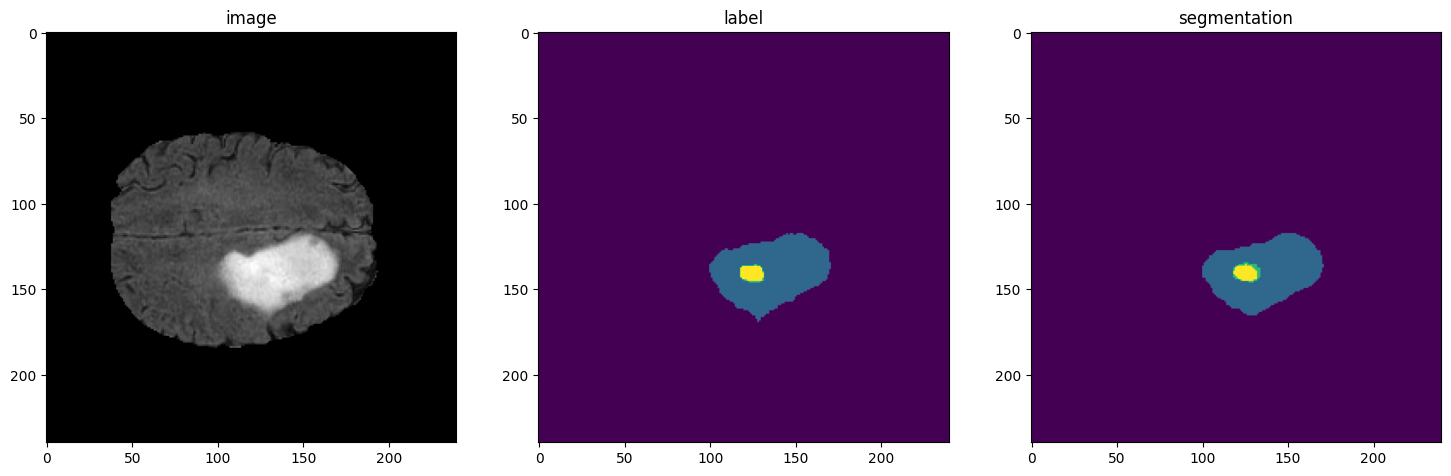

In [13]:
slice_num = 95
case_num = "469"


img_add = os.path.join(
    base_path,
    "imagesTr/BRATS_" + case_num + ".nii.gz",
)
label_add = os.path.join(
    base_path,
    "labelsTr/BRATS_" + case_num + ".nii.gz",
)


img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
infer = seg_infers[-16]

for i in range(label.shape[2]):
    if 1 in label[:, :, i] and 2 in label[:, :, i] and 3 in label[:, :, i]:
        print(i)
        break

plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num, 0], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(infer[:, :, slice_num])
plt.show()